Testing code to crop images based on cp masks

Making file_directory list

In [82]:
import os
import numpy as np
import pandas as pd


def make_file_directory(path_to_images, path_to_csv):
    # Open csv file as pandas
    cp_file_df = pd.read_csv(path_to_csv)

    # Reduce the df to the columns needed
    cp_file_df = cp_file_df[['ImageNumber', 'ObjectNumber', 'Metadata_Experiment', 'Metadata_Treatment', 'AreaShape_Center_X', 'AreaShape_Center_Y','FileName_Image']]
    
    #check file lists
    print(f"cp_file_df has shape: {cp_file_df.shape}")
    return cp_file_df

path_to_images = "/mnt/efs/aimbl_2025/student_data/S-DD/CP_images/MAXPRJ/"
path_to_csv = "/mnt/efs/aimbl_2025/student_data/S-DD/LD088-LD089-LD090-LD093-Nucleoli2-Nuclei.csv"

#check if path exists
if not os.path.exists(path_to_images):
    print(f"Error: directory '{path_to_images}' does not exist")
if not os.path.exists(path_to_csv):
    print(f"Error: csv file {path_to_csv} does not exist")    
# make file info dataframe by reading csv and deleting unnecesary columns
cp_file_df = make_file_directory(path_to_images, path_to_csv)
print(cp_file_df)

cp_file_df has shape: (11728, 7)
       ImageNumber  ObjectNumber Metadata_Experiment Metadata_Treatment  \
0                1             1               LD088          10uMmg132   
1                1             2               LD088          10uMmg132   
2                1             3               LD088          10uMmg132   
3                1             4               LD088          10uMmg132   
4                1             5               LD088          10uMmg132   
...            ...           ...                 ...                ...   
11723          950            16               LD093               DMSO   
11724          950            17               LD093               DMSO   
11725          950            18               LD093               DMSO   
11726          950            19               LD093               DMSO   
11727          950            20               LD093               DMSO   

       AreaShape_Center_X  AreaShape_Center_Y  \
0               8

Finding image pairs

In [83]:
def obtain_image_paths(cp_file_df, image_num, path_to_images):
    row_info_df = cp_file_df.loc[cp_file_df['ImageNumber'] == image_num].iloc[0]
    file_path_prj = row_info_df['FileName_Image']
    base_file_name = file_path_prj.removesuffix('.tif')
    file_path_mask = base_file_name + 'Nuclei.tiff'
    file_prj = path_to_images + file_path_prj
    file_mask = path_to_images + file_path_mask
    return (file_prj, file_mask)

image_num = 231
file_prj, file_mask = obtain_image_paths(cp_file_df, image_num, path_to_images)
print(file_prj)
print(file_mask)

/mnt/efs/aimbl_2025/student_data/S-DD/CP_images/MAXPRJ/LD088-RPE1hTERT-1uMdoxo-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m000_MAXPRJ.tif
/mnt/efs/aimbl_2025/student_data/S-DD/CP_images/MAXPRJ/LD088-RPE1hTERT-1uMdoxo-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m000_MAXPRJNuclei.tiff


Locate and crop object (nucleus)

In [ ]:
import skimage.io
import numpy as np

from skimage.measure import label, regionprops

def crop_object(file_prj, file_mask, object_num):
    # convert images to numpy arrays
    prj = skimage.io.imread(file_prj)
    mask = skimage.io.imread(file_mask)
    print(f"prj shape: {prj.shape}")
    print(f"mask_shape: {mask.shape}")
    #get centroid coordinates for object_num
    centroid_x = cp_file_df.loc[(cp_file_df['ImageNumber'] == image_num) & (cp_file_df['ObjectNumber']== object_num), 'AreaShape_Center_X'].iloc[0]
    centroid_y = cp_file_df.loc[(cp_file_df['ImageNumber'] == image_num) & (cp_file_df['ObjectNumber']== object_num), 'AreaShape_Center_Y'].iloc[0]
    centroid_x = int(centroid_x)
    centroid_y = int(centroid_y)
    print(f"Centroid for image_num = {image_num} and object_num = {object_num} is x= {centroid_x} and y= {centroid_y}")
    # Adding padding
    padded_mask = np.pad(mask, pad_width=((64, 64), (64, 64), (0,0)), mode='constant', constant_values=0)
    padded_prj = np.pad(prj, pad_width=((64, 64), (64, 64), (0,0)), mode='symmetric')
    # Determine bounding box boundaries. Note that this takes into account the padding in the previous step
    bounding_box = [(centroid_x), (centroid_x+128), (centroid_y),(centroid_y+128)]
    print(f"the image and object number are: {image_num, object_num}")
    print(f'bounding box is: {bounding_box}, first argument is {bounding_box[0]}')
    prj_crop = padded_prj[bounding_box[2]:bounding_box[3], bounding_box[0]:bounding_box[1], :]
    mask_crop = padded_mask[bounding_box[2]:bounding_box[3], bounding_box[0]:bounding_box[1], :]
    return prj_crop, mask_crop

object_num = 1

prj_crop, mask_crop = crop_object(file_prj, file_mask, object_num)
print(f"cropped projection image: {prj_crop.shape}")
print(f"cropped mask image: {mask_crop.shape}")



prj shape: (512, 512, 3)
mask_shape: (512, 512, 3)
Centroid for image_num = 231 and object_num = 1 is x= 167 and y= 36
the image and object number are: (231, 1)
bounding box is: [167, 295, 36, 164], first argument is 167
cropped projection image: (128, 128, 3)
cropped mask image: (128, 128, 3)


Visualizing cropped images

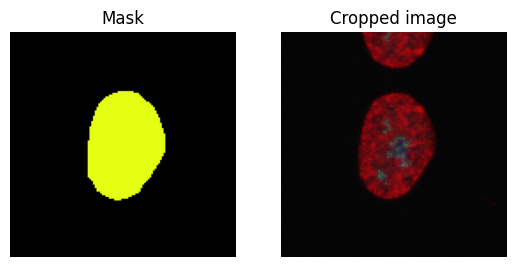

In [109]:
import matplotlib.pyplot as plt

#load examples
def plot_cropped_images(prj_crop, mask_crop):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(mask_crop)
    axes[0].set_title(f"Mask")
    axes[0].axis("off")
    axes[1].imshow(prj_crop)
    axes[1].set_title(f"Cropped image")
    axes[1].axis("off")
    plt.show()

plot_cropped_images(prj_crop, mask_crop)